In [1]:
import numpy as np
import matplotlib.pyplot as plt
import exoplanet as exo
import theano.tensor as T
import lightkurve as lk
import pymc3 as pm

import datetime
import os
import csv

from   astropy.io import fits as pyfits

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise

In [2]:
# set directory and csv file
PRIMARY_DIR   = '/Users/research/projects/alderaan/'
CSV_FILE_PHYS = '/Users/research/projects/alderaan/Catalogs/simulations_physical.csv'
CSV_FILE_OBS  = '/Users/research/projects/alderaan/Catalogs/simulations_observed.csv'

# automatically generate an ID for the simulation
dt = datetime.datetime.now()

SIM_ID = str(dt.year) + str(dt.month).zfill(2) + str(dt.day).zfill(2) 
SIM_ID += str(dt.hour).zfill(2) + str(dt.minute).zfill(2) + str(dt.second).zfill(2)

# set paths to save simulation data
SIM_DIR = PRIMARY_DIR + 'Simulations/'

# check if all the paths exist and create them if not
if os.path.exists(SIM_DIR) == False:
    os.mkdir(SIM_DIR)
    
if os.path.exists(CSV_FILE_PHYS) == False:
    with open(CSV_FILE_PHYS, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(["id_sim", "kic", "rstar", "mstar", "u1", "u2", "npl", \
                         "epoch", "period", "radius", "impact"])

if os.path.exists(CSV_FILE_OBS) == False:
    with open(CSV_FILE_OBS, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(["id_sim", "kic", "rstar", "mstar", "u1", "u2", "npl", \
                         "epoch", "period", "depth", "dur", "impact"])

In [3]:
KIC = 0

# First set up the transit-free time, flux, and error arrays

In [4]:
# set observation baseline parameters [days]
TMIN    = 0.
TMAX    = 1600.
Q0_TIME = 30.                            # length of commissioning quarter
Q_TIME  = 91.                            # length of an observing quarter
DL_TIME = (365.25 - 4*Q_TIME)/4          # length of a data download

# choose which quarters to simulate
QUARTERS = np.arange(5)
CADENCES = ['long', 'long', 'short', 'short', 'short']

# set noise level
NOISE_PPM = np.abs(np.random.normal(loc=1000, scale=100))

In [5]:
# clean up time arrays so everything is compatible w/ long cadence
Q0_TIME = Q0_TIME - Q0_TIME % (30*SCIT/3600/24)
Q_TIME  = Q_TIME - Q_TIME % (30*SCIT/3600/24)
DL_TIME = DL_TIME - DL_TIME % (30*SCIT/3600/24)

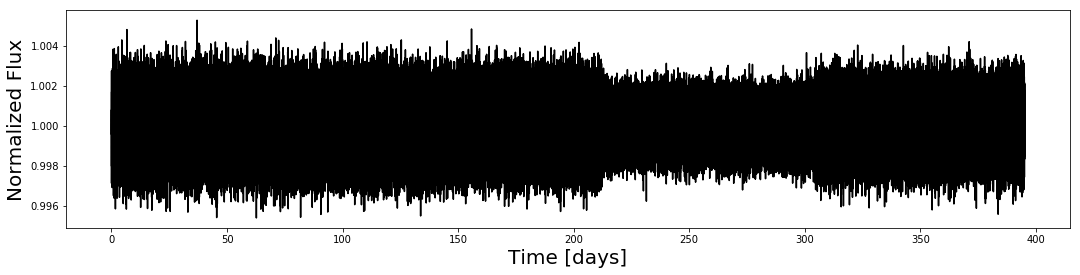

In [6]:
time_sc  = []
flux_sc  = []
error_sc = []
cadno_sc = []

for q in QUARTERS:
    # make time array
    if q == 0:
        tq = np.arange(TMIN, TMIN + Q0_TIME, SCIT/3600/24)
        
    elif q > 0:
        tmin = TMIN + Q0_TIME + DL_TIME + (q-1)*(Q_TIME + DL_TIME)
        tmax = tmin + Q_TIME
        tq   = np.arange(tmin, tmax, SCIT/3600/24)

    # set noise properties
    nq = np.abs(np.random.normal(loc=NOISE_PPM, scale=0.1*NOISE_PPM))

    # save simulated data
    time_sc.append(tq)
    flux_sc.append(np.ones_like(tq) + (nq*1e-6)*np.random.normal(size=len(tq)))
    error_sc.append((nq*1e-6)*np.ones_like(tq))
    cadno_sc.append(np.array(tq/(SCIT/3600/24), dtype='int'))
    
    
plt.figure(figsize=(18,4))
plt.plot(np.hstack(time_sc), np.hstack(flux_sc), c='k')
plt.xlabel('Time [days]', fontsize=20)
plt.ylabel('Normalized Flux', fontsize=20)
plt.show()

# Inject planet transit signals

In [7]:
# set number of planets
NPL = 2

# assume a solar twin
RSTAR = 1.0
MSTAR = 1.0

U1 = 0.39940842
U2 = 0.26477268
UCOEFFS = [U1, U2]

# RADIUS drawn from log-uniform distrubution between 2.5*R_earth and R_jup [in units of stellar radii]
LOGR = np.random.uniform(low=np.log(2*RSTAR/RSRE), high=np.log(RSTAR/RSRJ), size=NPL)
RADII = np.exp(LOGR)

# PERIOD drawn from log-uniform distribution between 3 and 100 days
LOGP = np.random.uniform(low=np.log(3), high=np.log(100), size=NPL)
PERIODS = np.exp(LOGP)

# EPOCH drawn randomly
EPOCHS = np.random.uniform(low=0, high=PERIODS, size=NPL)

# IMPACT parameter drawn from uniform distribution between 0 and 1-RP/RS
IMPACTS = np.random.uniform(low=0, high=1-RADII/RSTAR, size=NPL)

In [8]:
PERIODS, RADII

(array([17.47083133, 63.33508379]), array([0.02377938, 0.07991191]))

/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


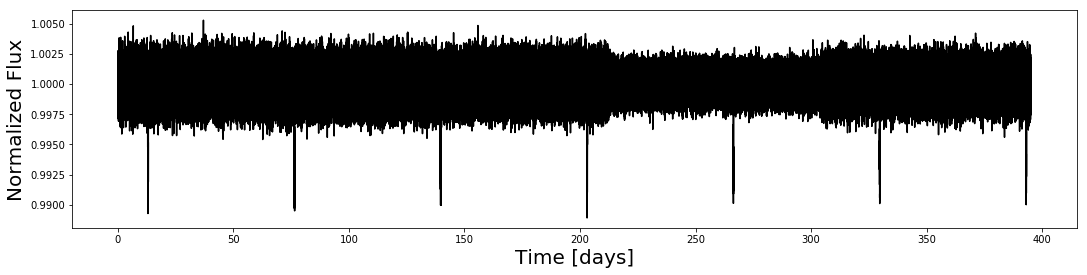

In [9]:
exoSLC = exo.LimbDarkLightCurve([U1,U2])
orbit = exo.orbits.KeplerianOrbit(period=PERIODS, t0=EPOCHS, b=IMPACTS)

for i, q in enumerate(QUARTERS):
    flux_sc[i] += np.sum(exoSLC.get_light_curve(orbit=orbit, r=RADII, t=time_sc[i]).eval(), axis=-1)
    
    
plt.figure(figsize=(18,4))
plt.plot(np.hstack(time_sc), np.hstack(flux_sc), c='k')
plt.xlabel('Time [days]', fontsize=20)
plt.ylabel('Normalized Flux', fontsize=20)
plt.show()

# Bin it up to long cadence

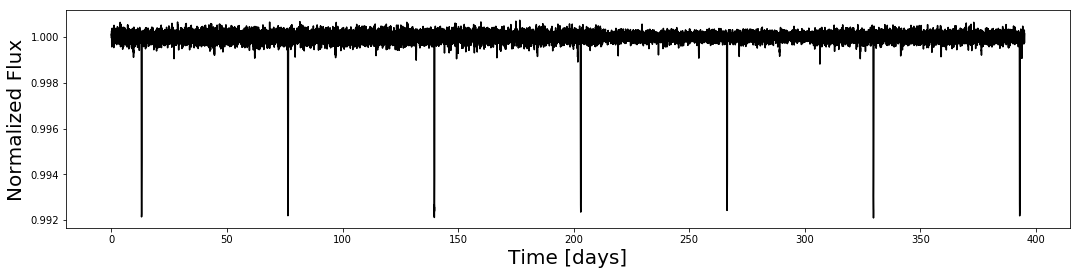

In [10]:
time_lc = []
flux_lc = []
error_lc = []
cadno_lc = []

for i, q in enumerate(QUARTERS):
    time_lc.append(time_sc[i].reshape((-1,30)).mean(axis=-1))
    flux_lc.append(flux_sc[i].reshape((-1,30)).mean(axis=-1))
    error_lc.append(error_sc[i].reshape((-1,30)).mean(axis=-1)/np.sqrt(30))
    cadno_lc.append(cadno_sc[i][::30])
    
    
plt.figure(figsize=(18,4))
plt.plot(np.hstack(time_lc), np.hstack(flux_lc), c='k')
plt.xlabel('Time [days]', fontsize=20)
plt.ylabel('Normalized Flux', fontsize=20)
plt.show()

# Combine short and long cadence

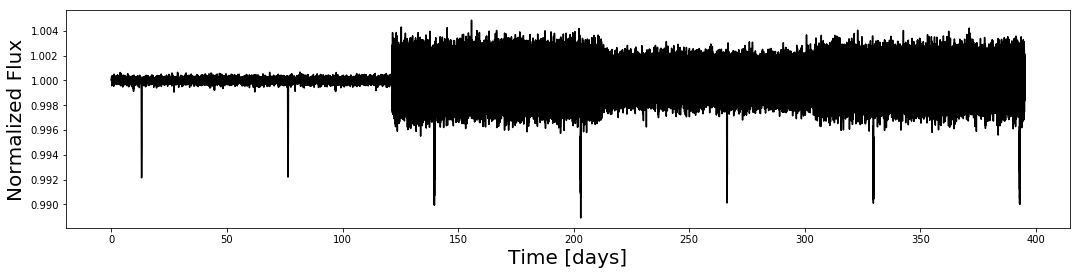

In [11]:
time = []
flux = []
error = []
cadno = []

for i, cad in enumerate(CADENCES):
    if cad == 'short':
        time.append(time_sc[i])
        flux.append(flux_sc[i])
        error.append(error_sc[i])
        cadno.append(cadno_sc[i])
        
    if cad == 'long':
        time.append(time_lc[i])
        flux.append(flux_lc[i])
        error.append(error_lc[i])
        cadno.append(cadno_lc[i])

        
plt.figure(figsize=(18,4))
plt.plot(np.hstack(time), np.hstack(flux), c='k')
plt.xlabel('Time [days]', fontsize=20)
plt.ylabel('Normalized Flux', fontsize=20)
plt.show()

# Fit a simple Keplerian model to LC data to simulate observations

In [12]:
time1d = np.hstack(time_lc)
flux1d = np.hstack(flux_lc)
error1d = np.hstack(error_lc)

In [13]:
with pm.Model() as kep_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u')

    Rstar = pm.Normal('Rstar', mu=RSTAR, sd=0.1*RSTAR)
    Mstar = pm.Normal('Mstar', mu=MSTAR, sd=0.1*MSTAR)

    
    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    
    b  = exo.distributions.ImpactParameter('b', ror=rp/Rstar, shape=NPL)
    
    P  = pm.Normal('P', mu=PERIODS, sd=0.01, shape=NPL)
    T0 = pm.Normal('T0', mu=EPOCHS, sd=0.1, shape=NPL)

    # nuisance parameters
    flux0  = pm.Normal('flux0', mu=1.0, sd=0.1)    
    
    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.KeplerianOrbit(period=P, t0=T0, b=b, r_star=Rstar, m_star=Mstar)

    light_curves = exoSLC.get_light_curve(orbit=orbit, r=rp, t=time1d)
    summed_light_curve = pm.math.sum(light_curves, axis=-1) + flux0
    model_flux = pm.Deterministic('model_flux', summed_light_curve)
    
    obs = pm.Normal("obs", mu=model_flux, sd=error1d, observed=flux1d)

/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [14]:
with kep_model:
    kep_map = exo.optimize(start=kep_model.test_point)

optimizing logp for variables: [flux0, T0, P, b, logr, Mstar, Rstar, u]
0it [00:00, ?it/s]/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
255it [00:01, 228.42it/s, logp=1.390521e+05]/Users/research/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
267it [00:01, 228.42it/s, logp=1.390521e+05]/Users/research/an

In [15]:
Rstar  = kep_map['Rstar']
Mstar  = kep_map['Mstar']
u1, u2 = kep_map['u']

epochs  = kep_map['T0']
periods = kep_map['P']
impacts = kep_map['b']
depths  = kep_map['rp']**2 * 1e6
durs    = 13*(periods/365.25)**(1/3)*np.sqrt(1-impacts**2)   # Winn (2010) Eq. 19, neglecting rho_star

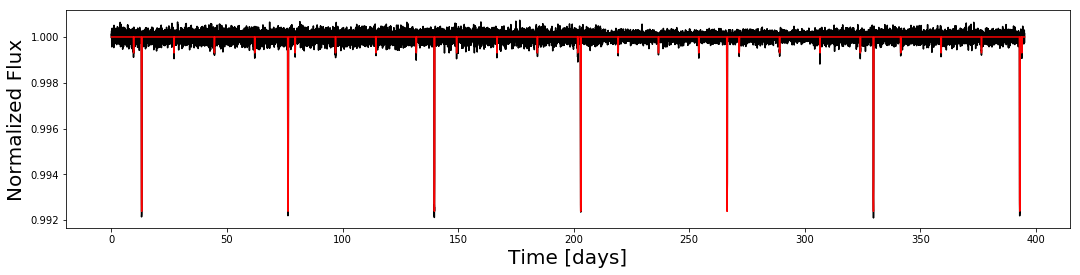

In [16]:
plt.figure(figsize=(18,4))
plt.plot(time1d, flux1d, c='k')
plt.plot(time1d, kep_map['model_flux'], c='r')
plt.xlabel('Time [days]', fontsize=20)
plt.ylabel('Normalized Flux', fontsize=20)
plt.show()

# Save each quarter of simulated data as a separate .fits file

In [17]:
# set savepath
TARGET_DIR = SIM_DIR + SIM_ID + '/'

# check if all the paths exist and create them if not
if os.path.exists(TARGET_DIR) == False:
    os.mkdir(TARGET_DIR)

    
for i, q in enumerate(QUARTERS):
    # make the PrimaryHDU and header
    primaryHDU = pyfits.PrimaryHDU()
    header = primaryHDU.header

    header['TARGET']   = 'SIMULATED'
    header['SIMID']    = (SIM_ID, 'simulation identifier')
    header['KIC']      = (KIC, 'Kepler Input Catalog ID')
    header['QUARTER']  = (q, 'quarter')
    header['CADENCE']  = (CADENCES[i], 'cadence type (short/long)')
    header['CHANNEL']  = (-99, 'channel')

    # make the time array
    timeHDU    = pyfits.ImageHDU(time[i], name='time')
    fluxHDU    = pyfits.ImageHDU(flux[i], name='flux')
    errorHDU   = pyfits.ImageHDU(error[i], name='error')
    cadnoHDU   = pyfits.ImageHDU(cadno[i], name='cadno')
    qualityHDU = pyfits.ImageHDU(np.zeros(len(cadno[i]), dtype='int'), name='quality')

    # now make the HDU list
    hdulist = pyfits.HDUList([primaryHDU, timeHDU, fluxHDU, errorHDU, cadnoHDU, qualityHDU])
    
    # and save it
    filename = TARGET_DIR + 'sim' + SIM_ID + '-q' + str(q).zfill(2)
    
    if CADENCES[i] == 'short': filename += '_sc.fits'
    if CADENCES[i] == 'long':  filename += '_lc.fits'
    
    hdulist.writeto(filename, overwrite=True)

# Save both "physical" and "observed" catalogs as .csv files

In [18]:
with open(CSV_FILE_PHYS, 'a+', newline='') as outfile:
    writer = csv.writer(outfile)
    
    for npl in range(NPL): 
        writer.writerow([SIM_ID, KIC, RSTAR, MSTAR, U1, U2, NPL, EPOCHS[npl], PERIODS[npl], RADII[npl], IMPACTS[npl]])

In [19]:
with open(CSV_FILE_OBS, 'a+', newline='') as outfile:
    writer = csv.writer(outfile)
    
    for npl in range(NPL): 
        writer.writerow([SIM_ID, KIC, Rstar, Mstar, u1, u2, NPL, \
                         epochs[npl], periods[npl], depths[npl], durs[npl], impacts[npl]])

In [20]:
SIM_ID

'20200325111052'